In [1]:
import numpy as np
import pandas as pd

In [2]:
fe_boru=pd.read_csv('rlogfe.csv')

In [3]:
fe_boru.outcome.value_counts()

1    299
0     28
Name: outcome, dtype: int64

In [4]:
fe_boru.head()

,outcome,KRT80,SCGN,CDH3,CEMIP,BEST4,ESM1,GLP2R,OTOP2,SCARA5,...,SLC30A10,SLC25A23,TMEM100,TMEM253,GUCA2A,PLP1,SPIB,CADM3,PLPP1,KRT24
0,1,11.931829,3.059055,12.616037,12.599462,6.174449,7.169737,5.094664,3.059055,7.604472,...,4.420463,11.768730,1.265924,5.263310,7.507449,5.094664,3.677475,3.059055,9.569704,1.265924
1,1,10.204798,3.589669,11.413810,11.094808,4.833274,8.301505,5.164854,2.908608,6.515436,...,2.247362,10.884379,4.477869,4.199496,7.642718,4.259772,4.999964,4.833274,9.035718,1.265924
2,1,9.281589,5.049195,11.603694,12.061467,4.793745,6.954222,4.593755,3.916945,4.884082,...,2.471627,11.058882,4.227935,5.265790,9.506518,4.081150,6.681396,4.081150,9.719452,1.265924
3,1,8.796657,3.331911,10.615035,13.135689,6.201120,7.666343,4.975577,4.209370,7.442664,...,3.498091,10.392663,4.677310,6.005125,8.977852,3.498091,4.537911,2.915227,9.250811,1.265924
4,1,9.517437,1.892910,12.067773,12.129539,6.261376,5.840656,3.864255,1.265924,3.211085,...,3.910455,11.095175,2.955137,5.680822,5.530132,2.145905,2.955137,1.892910,8.764261,1.265924


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from collections import Counter
import seaborn as sns
import smote


## PCA

In [6]:
#pca
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
df=fe_boru.drop('outcome', axis=1)
scaler.fit(df)
scaled_data=scaler.transform(df)

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [8]:
pca=PCA(n_components=5)
pca.fit(scaled_data)
x_pca=pca.transform(scaled_data)


In [9]:
t=np.asarray(fe_boru.outcome)
t=t.astype(object)

In [10]:

for i in range(len(t)):
    if t[i]==1:
        t[i]='cancer'
    else:
        t[i]='non-cancer'
    

In [11]:
pc_df=pd.DataFrame(data=x_pca,columns=['PC1','PC2','PC3','PC4','PC5'])
pc_df['cluster']=t


In [12]:
scaled_data.shape

(327, 61)

In [13]:
x_pca.shape

(327, 5)

In [14]:
var= pca.explained_variance_ratio_

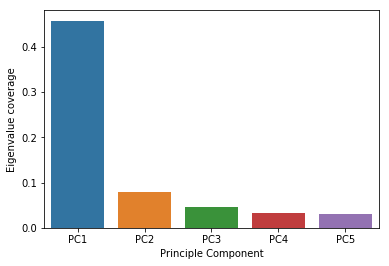

In [15]:
ex =pd.DataFrame({'Eigenvalue coverage':var,'Principle Component':['PC1','PC2','PC3','PC4','PC5']})
sns.barplot(x='Principle Component',y='Eigenvalue coverage',data=ex)

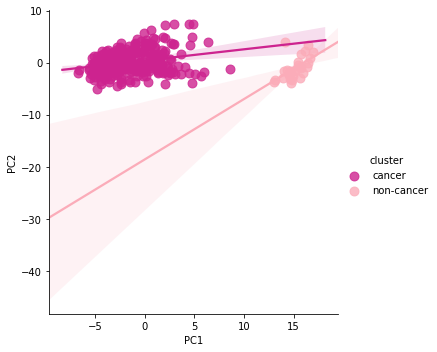

In [16]:
sns.lmplot(x='PC1',y='PC2', data=pc_df,hue='cluster',legend=True, palette='RdPu_r',
scatter_kws={"s": 80})

Text(0, 0.5, 'Second principle component')

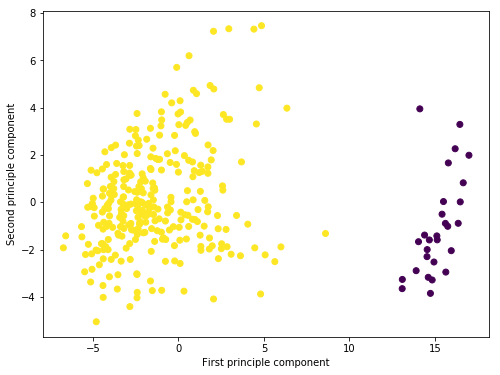

In [17]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1], c=fe_boru['outcome'])
plt.xlabel('First principle component')
plt.ylabel('Second principle component')

In [18]:
df_com = pd.DataFrame(pca.components_[0:2,:], columns=df.columns)

In [19]:
df_com

,KRT80,SCGN,CDH3,CEMIP,BEST4,ESM1,GLP2R,OTOP2,SCARA5,ETV4,...,SLC30A10,SLC25A23,TMEM100,TMEM253,GUCA2A,PLP1,SPIB,CADM3,PLPP1,KRT24
0,-0.152605,0.142855,-0.160822,-0.148371,0.139360,-0.151991,0.127372,0.165206,0.139345,-0.157074,...,0.138928,-0.002569,0.128085,0.083168,0.127855,0.139553,0.133506,0.135212,0.058677,0.148731
1,0.087057,0.065298,0.024945,0.079199,-0.119286,0.106761,0.143236,-0.126459,0.081040,0.030774,...,-0.143551,-0.126312,0.241726,-0.196160,-0.148905,0.196600,-0.038395,0.207814,0.236706,0.039630


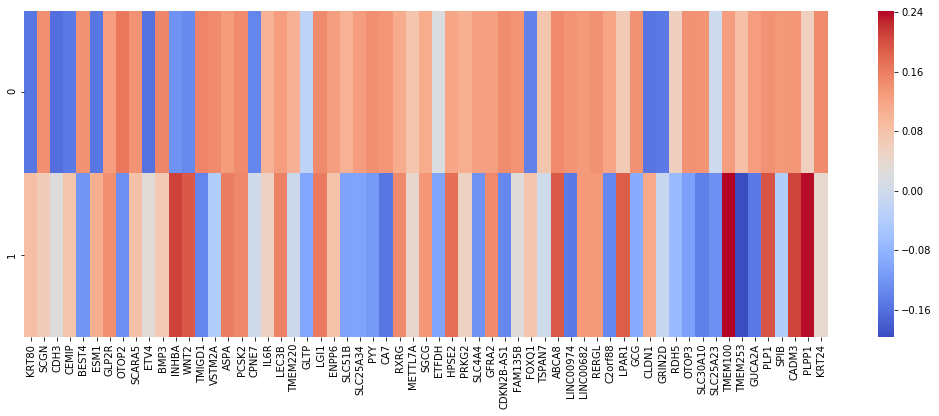

In [20]:
import seaborn as sns
plt.figure(figsize=(18,6))
sns.heatmap(df_com,cmap="coolwarm")

## the ML methods part

In [6]:
fe_boru=fe_boru.reindex(np.random.permutation(fe_boru.index))

In [7]:
X0=fe_boru[fe_boru['outcome']==0]
#X0=X0.reindex(np.random.permutation(X0.index))

In [8]:
X1=fe_boru[fe_boru['outcome']==1]
#X1=X1.reindex(np.random.permutation(X1.index))

In [9]:
X00=X0.drop('outcome',axis=1)
y00=X0['outcome']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X00, y00, 
                                                    test_size=0.33, 
                                                    random_state=50)

In [10]:
X11=X1.drop('outcome',axis=1)
y11=X1['outcome']
X_train0, X_test0, y_train0, y_test0 = train_test_split(X11, y11, 
                                                    test_size=0.33, 
                                                    random_state=50)

In [11]:
X_train=X_train1.append(pd.DataFrame(data=X_train0))
X_test=X_test1.append(pd.DataFrame(data=X_test0))
y_train=np.concatenate([y_train1,y_train0])
y_test=np.concatenate([y_test1,y_test0])

# testing with the imbalanced dataset

In [12]:
from collections import Counter
print(sorted(Counter(y_test).items()))


[(0, 10), (1, 99)]


In [13]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [14]:
pred_test=rf.predict(X_test)

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

In [16]:

print(classification_report(y_test,pred_test))
print('\n')
print(confusion_matrix(y_test,pred_test))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        10
          1       1.00      1.00      1.00        99

avg / total       1.00      1.00      1.00       109



[[10  0]
 [ 0 99]]


In [17]:
print(rf.feature_importances_)
feature_imp = pd.Series(rf.feature_importances_,index=list(fe_boru.drop('outcome',axis=1).columns.values)).sort_values(ascending=False)

[0.2        0.         0.         0.         0.         0.
 0.         0.18295987 0.01789417 0.1        0.         0.1
 0.09452261 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00877617 0.         0.         0.         0.
 0.         0.         0.06696694 0.00547739 0.         0.1
 0.         0.01704013 0.09122383 0.         0.         0.
 0.         0.01513889 0.         0.         0.         0.
 0.        ]


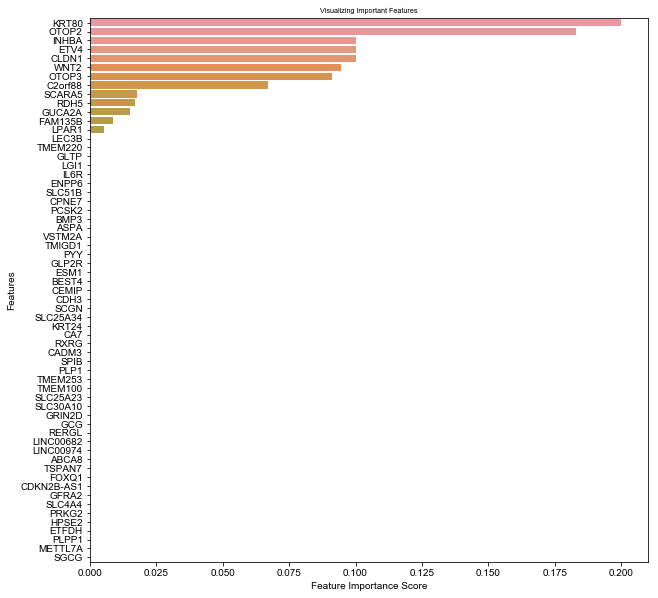

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(10,10))
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
sns.set(font_scale=0.6)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()
plt.savefig('importance ranking for female')
plt.close()


In [107]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf, random_state=101).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0130 ± 0.0091,INHBA
0.0093 ± 0.0000,ESM1
0.0093 ± 0.0000,GRIN2D
0.0093 ± 0.0000,SCARA5
0.0093 ± 0.0000,CA7
0.0056 ± 0.0091,CPNE7
0 ± 0.0000,PYY
0 ± 0.0000,SLC25A34
0 ± 0.0000,SLC51B
0 ± 0.0000,ENPP6


## adaboost with regular over sampling

In [19]:
#regular over sampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=50)
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)
from collections import Counter
print(sorted(Counter(y_resampled).items()))


[(0, 200), (1, 200)]


In [ ]:
model = AdaBoostClassifier(n_estimators=100, random_state=50)
model.fit(X_resampled, y_resampled)
y_over = model.predict(X_test)

In [21]:
print(classification_report(y_test, y_over))

             precision    recall  f1-score   support

          0       0.91      1.00      0.95        10
          1       1.00      0.99      0.99        99

avg / total       0.99      0.99      0.99       109



In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_over)

array([[10,  0],
       [ 1, 98]], dtype=int64)

0.994949494949495


Text(0.5, 0, 'False Positive Rate')

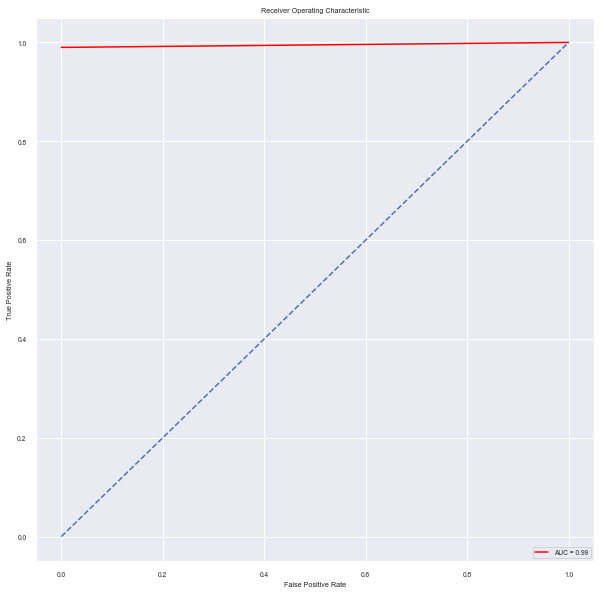

In [23]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_over)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [24]:
print(model.feature_importances_)
feature_imp = pd.Series(model.feature_importances_,index=list(fe_boru.drop('outcome',axis=1).columns.values)).sort_values(ascending=False)

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


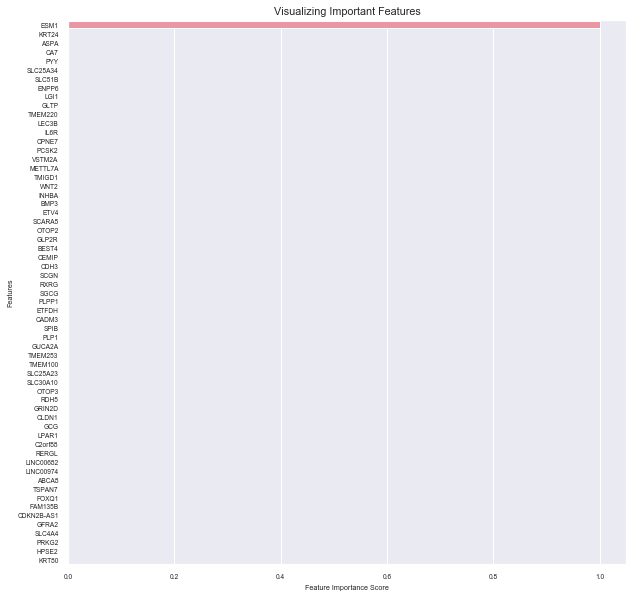

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(10,10))
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
sns.set(font_scale=0.9)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()
plt.savefig('importance ranking for female')
plt.close()


In [26]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel

perm = PermutationImportance(model, random_state=101).fit(X_test, y_test)

sel = SelectFromModel(perm, threshold=0.05, prefit=True)
X_trans = sel.transform(X_test)


In [27]:
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.1578 ± 0.0180,ESM1
0 ± 0.0000,PCSK2
0 ± 0.0000,CA7
0 ± 0.0000,PYY
0 ± 0.0000,SLC25A34
0 ± 0.0000,SLC51B
0 ± 0.0000,ENPP6
0 ± 0.0000,LGI1
0 ± 0.0000,GLTP
0 ± 0.0000,TMEM220


## adaboost with SMOTE

In [28]:
# SMOTE
print('Original dataset shape %s' % Counter(y_train))
sm = SMOTE(random_state=50)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train_sm))


Original dataset shape Counter({1: 200, 0: 18})
Resampled dataset shape Counter({0: 200, 1: 200})


In [29]:
model = AdaBoostClassifier(n_estimators=100, random_state=50)
m1=model.fit(X_train_sm, y_train_sm)
y_smote = model.predict(X_test)


In [30]:
print(classification_report(y_test, y_smote))

             precision    recall  f1-score   support

          0       0.91      1.00      0.95        10
          1       1.00      0.99      0.99        99

avg / total       0.99      0.99      0.99       109



In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_smote)

array([[10,  0],
       [ 1, 98]], dtype=int64)

0.994949494949495


Text(0.5, 0, 'False Positive Rate')

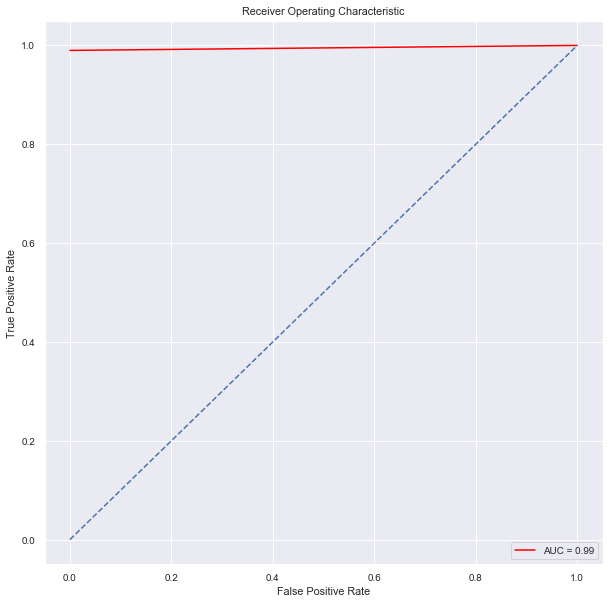

In [32]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_smote)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [33]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(m1, random_state=50).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.1615 ± 0.0275,ESM1
0 ± 0.0000,PCSK2
0 ± 0.0000,CA7
0 ± 0.0000,PYY
0 ± 0.0000,SLC25A34
0 ± 0.0000,SLC51B
0 ± 0.0000,ENPP6
0 ± 0.0000,LGI1
0 ± 0.0000,GLTP
0 ± 0.0000,TMEM220


## RF with SMOTE/random over sampling

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
#regular over sampling
#from imblearn.over_sampling import RandomOverSampler
#ros = RandomOverSampler(random_state=101)
#X_resampled, y_resampled = ros.fit_sample(X_train, y_train)
#from collections import Counter
#print(sorted(Counter(y_resampled).items()))

In [36]:
clf2 = RandomForestClassifier(n_estimators=100, max_depth=2,
                               random_state=50)
clf2.fit(X_resampled, y_resampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=50, verbose=0, warm_start=False)

In [37]:
y_pred=clf2.predict(X_test)

In [38]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        10
          1       1.00      1.00      1.00        99

avg / total       1.00      1.00      1.00       109



In [39]:
print(clf2.feature_importances_)
feature_imp = pd.Series(clf2.feature_importances_,index=list(fe_boru.drop('outcome',axis=1).columns.values)).sort_values(ascending=False)

[9.00000000e-02 0.00000000e+00 6.01994724e-02 8.00000000e-02
 3.14017568e-02 8.16784069e-02 2.63323363e-02 2.98691294e-02
 1.98609732e-04 9.02959601e-02 3.88232690e-02 1.10976009e-01
 8.02776844e-02 9.50944843e-03 0.00000000e+00 2.96040167e-04
 1.98506241e-04 7.06753201e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.84236071e-04 9.96810207e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.52875450e-03
 0.00000000e+00 2.99307638e-04 0.00000000e+00 9.99550202e-05
 0.00000000e+00 0.00000000e+00 1.22498823e-02 1.82571483e-02
 9.23091475e-03 1.00008183e-02 5.04612660e-02 0.00000000e+00
 8.68522997e-03 0.00000000e+00 0.00000000e+00 1.84122785e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00970603e-02
 2.10509643e-02 1.98506241e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.74749435e-04 0.00000000e+00 8.46252703e-03
 0.00000000e+00 1.95080279e-02 0.00000000e+00 7.71177250e-04
 2.95566502e-04]


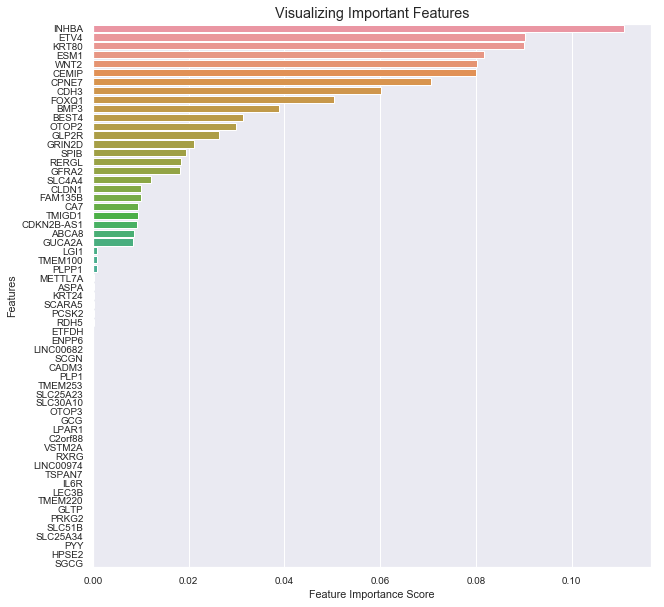

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(10,10))
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
sns.set(font_scale=1.2)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()
plt.savefig('importance ranking for female')
plt.close()


In [41]:
perm = PermutationImportance(clf2, random_state=101).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

C:\Users\User\Anaconda3\lib\site-packages\eli5\formatters\html.py:234: RuntimeWarning: invalid value encountered in double_scalars
  rel_weight = (abs(weight) / weight_range) ** 0.7


Weight,Feature
0 ± 0.0000,PCSK2
0 ± 0.0000,CA7
0 ± 0.0000,PYY
0 ± 0.0000,SLC25A34
0 ± 0.0000,SLC51B
0 ± 0.0000,ENPP6
0 ± 0.0000,LGI1
0 ± 0.0000,GLTP
0 ± 0.0000,TMEM220
0 ± 0.0000,LEC3B


In [42]:
# with smote
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=50)
clf.fit(X_train_sm, y_train_sm)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=50, verbose=0, warm_start=False)

In [43]:
y_pred=clf.predict(X_test)

In [44]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        10
          1       1.00      1.00      1.00        99

avg / total       1.00      1.00      1.00       109



In [45]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[10,  0],
       [ 0, 99]], dtype=int64)

In [46]:
print(clf.feature_importances_)
feature_imp = pd.Series(clf.feature_importances_,index=list(fe_boru.drop('outcome',axis=1).columns.values)).sort_values(ascending=False)

[9.00000000e-02 0.00000000e+00 6.01994724e-02 8.00000000e-02
 3.01866330e-02 8.16784069e-02 3.50217204e-02 1.95081084e-02
 2.84303530e-02 9.02959601e-02 3.82463072e-02 1.10976009e-01
 8.07656447e-02 8.94966769e-03 9.21538622e-03 0.00000000e+00
 1.98506241e-04 7.13964530e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.86794109e-04 9.96810207e-05
 0.00000000e+00 0.00000000e+00 8.60354699e-03 1.01131154e-02
 0.00000000e+00 2.99307638e-04 1.98024753e-04 9.99550202e-05
 0.00000000e+00 0.00000000e+00 1.21672176e-02 2.95736336e-04
 1.60631359e-03 1.00008183e-02 4.95989657e-02 0.00000000e+00
 8.76350620e-03 5.82147156e-04 0.00000000e+00 1.00849099e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00970603e-02
 2.03607901e-02 1.98506241e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.95767986e-05 0.00000000e+00 4.00627187e-04
 0.00000000e+00 1.95080279e-02 0.00000000e+00 7.71177250e-04
 2.95566502e-04]


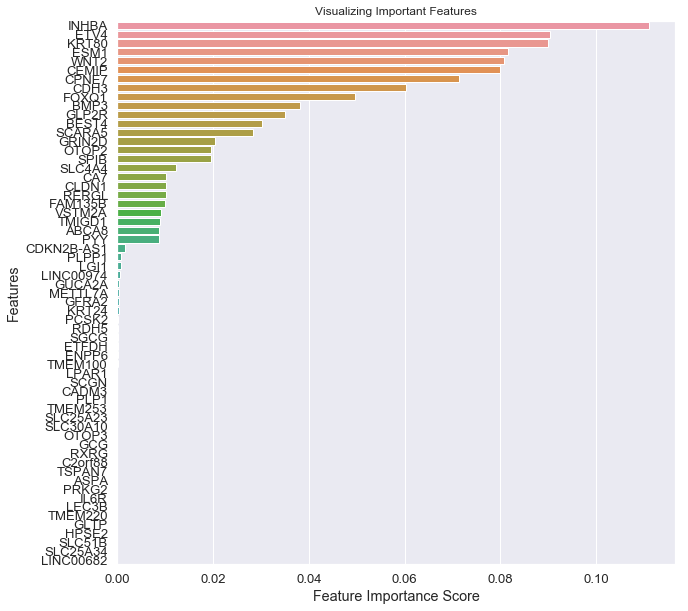

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(10,10))
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
sns.set(font_scale=1)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()
plt.savefig('importance ranking for female')
plt.close()


1.0


Text(0.5, 0, 'False Positive Rate')

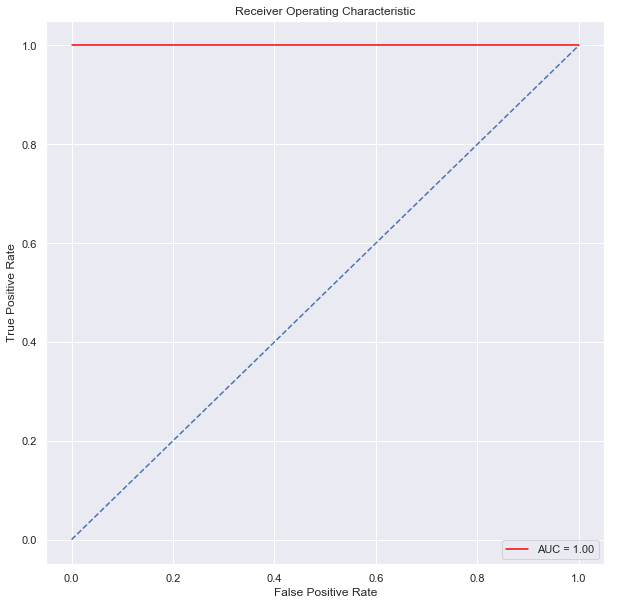

In [48]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [43]:

perm = PermutationImportance(clf, random_state=50).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

C:\Users\User\Anaconda3\lib\site-packages\eli5\formatters\html.py:234: RuntimeWarning: invalid value encountered in double_scalars
  rel_weight = (abs(weight) / weight_range) ** 0.7


Weight,Feature
0 ± 0.0000,PCSK2
0 ± 0.0000,CA7
0 ± 0.0000,PYY
0 ± 0.0000,SLC25A34
0 ± 0.0000,SLC51B
0 ± 0.0000,ENPP6
0 ± 0.0000,LGI1
0 ± 0.0000,GLTP
0 ± 0.0000,TMEM220
0 ± 0.0000,LEC3B


## smoteboost

In [49]:
target_names = ['No Cancer', 'Cancer']
for algorithm in [smote.SMOTEBoost(n_estimators=50, n_samples=50)]:
    m3=algorithm.fit(X_train, y_train)
    y_predd = model.predict(X_test)
    print()
    print(str(algorithm))
    print()
    print(classification_report(y_test, y_predd,
                                target_names=target_names))


SMOTEBoost(algorithm='SAMME.R', base_estimator=None, k_neighbors=None,
      learning_rate=1.0, n_estimators=50, n_samples=50, random_state=None)

             precision    recall  f1-score   support

  No Cancer       0.91      1.00      0.95        10
     Cancer       1.00      0.99      0.99        99

avg / total       0.99      0.99      0.99       109



In [50]:
confusion_matrix(y_test, y_predd)

array([[10,  0],
       [ 1, 98]], dtype=int64)

In [51]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(m3, random_state=0).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.1578 ± 0.0180,INHBA
0 ± 0.0000,CA7
0 ± 0.0000,PYY
0 ± 0.0000,SLC25A34
0 ± 0.0000,SLC51B
0 ± 0.0000,ENPP6
0 ± 0.0000,LGI1
0 ± 0.0000,GLTP
0 ± 0.0000,TMEM220
0 ± 0.0000,PCSK2


0.994949494949495


Text(0.5, 0, 'False Positive Rate')

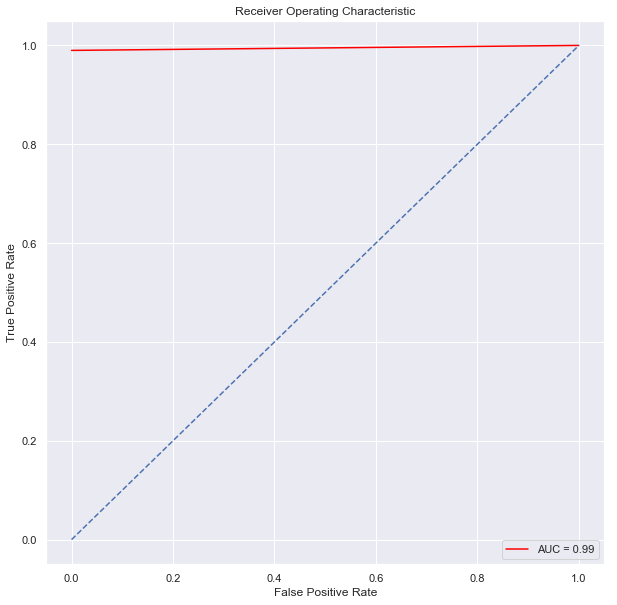

In [52]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predd)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')